#### ! 선행 설치 모듈 및 라이브러리

In [1]:
%pip install seaborn
%pip install nltk
%pip install googletrans==4.0.0-rc1
%pip install keras
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import sklearn
import csv
import re
import nltk
import hashlib
import pickle
from googletrans import Translator
from imblearn.over_sampling import SMOTE
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import time
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\정재현\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\정재현\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\정재현\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\정재현\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\정재현\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# 1. 데이터 확인 및 전처리

먼저 컬럼별 어떤 데이터를 넣어놨고 데이터에 오류나 결측치가 있는지 확인

이후 데이터의 type이나 기입되어 있는 데이터들이 어떤 형식으로 되어있는지 확인한 다음 데이터 전처리를 실시

In [3]:
df = pd.read_csv("./amazon_uk_shoes_products_dataset_2021_12.csv", encoding='utf-8') 
df.head()

,url,product_name,reviewer_name,review_title,review_text,review_rating,verified_purchase,review_date,helpful_count,uniq_id,scraped_at
0,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Jocelyn McSayles,Love em,Love these. Was looking for converses and thes...,5.0,True,Reviewed in the United States on 2 June 2020,2 people found this helpful,36eae4e5-2894-5279-a0b7-d2b330e2b814,24/12/2021 02:26:25
1,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Kenia Rivera,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0,True,Reviewed in the United States on 28 October 2021,NaN,f4778bb8-3070-5cb1-b5aa-ffce41a97b57,24/12/2021 02:26:25
2,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Chris Souza,Good quality,Good quality,5.0,True,Reviewed in the United States on 20 January 2021,NaN,db5a7525-d40b-5265-84d8-df4f29837a3b,24/12/2021 02:26:25
3,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Amazon Customer,Good,Great,5.0,True,Reviewed in the United States on 22 April 2021,NaN,75a42851-6462-54b5-988a-27d336221943,24/12/2021 02:26:25
4,https://www.amazon.co.uk/dp/B08SW434MG,"GUESS Women's Bradly Gymnastics Shoe, White, 7 UK",Graziella,PERFETTE!!,Ho scelto il modello bianco con rifinitura die...,5.0,True,Reviewed in Italy on 2 April 2021,2 people found this helpful,232dee43-849e-5d06-ba05-efb3f4814714,24/12/2021 02:26:25


In [4]:
# 로드된 데이터 프레임의 형태를 출력합니다 (형태는 행과 열의 수입니다)
print("데이터의 형태 (행, 열)는 " + str(df.shape) + " 입니다.")

데이터의 형태 (행, 열)는 (6823, 11) 입니다.


In [5]:
# 파일 경로
file_path = './amazon_uk_shoes_products_dataset_2021_12.csv'

# 첫 줄을 읽어서 컬럼 레이블을 확인합니다
with open(file_path, mode='r', encoding='utf-8') as file:
    reader = csv.reader(file)
    column_labels = next(reader)

# 컬럼 레이블을 한 줄씩 출력합니다
formatted_labels = "\n\n".join(column_labels)
print(formatted_labels)

url

product_name

reviewer_name

review_title

review_text

review_rating

verified_purchase

review_date

helpful_count

uniq_id

scraped_at


컬럼은 위와 같은 형태로 존재하는데 저 중에서 필요한 데이터는 사실상 review_title, review_text라고 판단

review_rating은 맥락이 필요한 텍스트(비꼬는 리뷰)에 필요할 수 있지만 우선은 rating 없이 시행
(가중치에서 얼마나 평점을 참조할지, 이로 인한 편향이 생길 수 있기 때문)


helpful_count가 물건에 대한 설명과 감정이 잘 드러난 데이터에 주로 많은 경향이 있어서 가중치로 사용할까 했지만 복잡해지고 정확도에 부정적인 영향을 끼칠 수 있기에 우선 제외

### (1) 특수문자 제거, 영어 번역, 불용어 제거, 제목과 본문 통합

원래 계획은 각각의 과정을 따로 시행하려 했지만 번역 과정에서 너무 많은 시간이 소요되는 문제가 발생

또한 6천개가 넘는 데이터를 매번 확인하며 전처리를 하는 것은 비효율적이라고 판단

따라서 모든 데이터 처리를 한번에 시행하며 영어 번역은 시행속도를 올리기 위해 병렬처리

해당 프로젝트는 평가에 중점을 두고 있으므로 번역파일을 따로 기재함

따라서 해당 코드를 실행할 필요가 없음

In [6]:
# 불용어 설정
stop_words = set(stopwords.words('english'))

# Google Translator 설정
translator = Translator()

# 번역 캐시 파일 경로
cache_file = './translation_cache.pkl'

# 번역 캐시 로드 또는 초기화
if os.path.exists(cache_file):
    with open(cache_file, 'rb') as f:
        translation_cache = pickle.load(f)
else:
    translation_cache = {}

# 텍스트 해시 함수
def text_hash(text):
    return hashlib.md5(text.encode()).hexdigest()

# 통합된 전처리 함수
def preprocess_and_translate(row):
    # 번역 함수 (캐시 사용 및 딜레이 추가)
    def translate_to_english(text):
        if not isinstance(text, str):
            text = ''
        text_key = text_hash(text)
        if text_key in translation_cache:
            return translation_cache[text_key]
        else:
            try:
                detected_lang = translator.detect(text).lang
                print(f"Detected language: {detected_lang}")
                translated = translator.translate(text, src=detected_lang, dest='en').text
                translation_cache[text_key] = translated
                # 딜레이 추가
                time.sleep(2)
                return translated
            except Exception as e:
                print(f"Translation error: {e}")
                return text  # 번역 실패 시 원본 텍스트 반환

    # 특수 문자 제거 함수
    def remove_special_characters(text):
        return re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # 텍스트 전처리 함수 (불용어 제거 포함)
    def preprocess_text(text):
        text = text.lower()  # 소문자 변환
        text = re.sub(r'\s+', ' ', text).strip()  # 여러 공백을 하나의 공백으로 변환하고 양쪽 공백 제거
        tokens = word_tokenize(text)
        filtered_tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(filtered_tokens)

    # 제목과 본문 통합
    title = row['review_title'] if pd.notna(row['review_title']) else ''
    review = row['review_text'] if pd.notna(row['review_text']) else ''
    combined = title + ' ' + review if title and review else title or review

    # 번역
    translated_text = translate_to_english(combined)
    
    # 특수 문자 제거 및 전처리
    translated_text = remove_special_characters(translated_text)
    cleaned_text = preprocess_text(translated_text)
    
    return cleaned_text

# 모든 리뷰 텍스트와 제목을 한 번에 전처리하고 번역 (진행 상황 표시)
tqdm.pandas(desc="Processing reviews")
df['processed_review'] = df.progress_apply(preprocess_and_translate, axis=1)

# 번역 캐시 저장
with open(cache_file, 'wb') as f:
    pickle.dump(translation_cache, f)

# 전처리된 리뷰 텍스트 확인
print(df['processed_review'].head())

# 필요한 컬럼만 선택하여 저장
output_file_path = './processed_reviews.csv'
df[['processed_review']].to_csv(output_file_path, index=False)

Processing reviews:  12%|█▏        | 837/6823 [00:01<00:07, 783.00it/s] 

Translation error: sequence item 1: expected str instance, NoneType found


Processing reviews:  17%|█▋        | 1162/6823 [00:01<00:07, 785.76it/s]

Translation error: sequence item 1: expected str instance, NoneType found


Processing reviews:  25%|██▍       | 1702/6823 [00:02<00:06, 787.47it/s]

Translation error: sequence item 1: expected str instance, NoneType found


Processing reviews:  31%|███       | 2092/6823 [00:02<00:05, 798.70it/s]

Translation error: sequence item 1: expected str instance, NoneType found


Processing reviews:  37%|███▋      | 2510/6823 [00:03<00:07, 543.38it/s]

Translation error: sequence item 1: expected str instance, NoneType found


Processing reviews:  39%|███▉      | 2694/6823 [00:03<00:07, 566.35it/s]

Translation error: sequence item 2: expected str instance, NoneType found


Processing reviews:  56%|█████▌    | 3818/6823 [00:04<00:03, 900.47it/s] 

Translation error: sequence item 1: expected str instance, NoneType found


Processing reviews:  63%|██████▎   | 4329/6823 [00:05<00:01, 1351.95it/s]

Translation error: sequence item 1: expected str instance, NoneType found


Processing reviews:  67%|██████▋   | 4597/6823 [00:05<00:03, 687.78it/s] 

Translation error: sequence item 1: expected str instance, NoneType found


Processing reviews:  98%|█████████▊| 6704/6823 [00:07<00:00, 1518.93it/s]

Translation error: sequence item 1: expected str instance, NoneType found


Processing reviews: 100%|██████████| 6823/6823 [00:07<00:00, 919.69it/s] 

Translation error: sequence item 2: expected str instance, NoneType found
0    love em love looking converses half price uniq...
1    plastic ripped shoes cute 2nd day wearing tong...
2                            good quality good quality
3                                           good great
4    perfect chose white model finish behind black ...
Name: processed_review, dtype: object


### (2) 스테밍 및 표제어 추출

In [7]:
# 전처리된 데이터 불러오기
df = pd.read_csv('./processed_reviews.csv')

# 데이터 타입 변환 및 NaN 값 처리
df['processed_review'] = df['processed_review'].astype(str).fillna('')

# 스테머 및 표제어 추출기 초기화
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# 스테밍 및 표제어 추출 함수
def stem_and_lemmatize(text):
    tokens = word_tokenize(text)
    stemmed_tokens = [ps.stem(word) for word in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]
    return ' '.join(lemmatized_tokens)

# 스테밍 및 표제어 추출 적용
df['processed_review'] = df['processed_review'].apply(stem_and_lemmatize)

# 결과 확인
print(df['processed_review'].head())

0    love em love look convers half price uniqu ive...
1    plastic rip shoe cute 2nd day wear tongu start...
2                            good qualiti good qualiti
3                                           good great
4    perfect chose white model finish behind black ...
Name: processed_review, dtype: object


# 2. 모델 구현

수업시간에 이용한 varder을 사용하여 모델을 구현

위에서 기술했듯 평점을 가중치로 넣거나 '이 평가가 도움이 됨'같은 항목을 가중치로 넣으려 했으나

편향이 너무 크게 생길 수 있기에 우선은 배제하고 순수하게 varder모델에서 텍스트만으로 시행

In [8]:
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    scores = sid.polarity_scores(text)
    return scores['compound']

df['sentiment_score'] = df['processed_review'].apply(analyze_sentiment)

# 감성 레이블 설정
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 1 if x >= 0 else 0)

In [9]:
# 필요한 컬럼만 선택하여 저장
output_file_path = './sentiment_analysis_results.csv'
df[['processed_review', 'sentiment_score', 'sentiment_label']].to_csv(output_file_path, index=False)

모델을 통하여 감성분석 점수 데이터 프레임 컬럼을 기입

# 3. 모델학습 및 튜닝

In [12]:
# 데이터셋 분할
X = df['processed_review']
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 로지스틱 회귀 모델
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# 예측
y_pred = model.predict(X_test_tfidf)

그리드 서치 방법을 통해 최적의 하이퍼 파라미터를 구하여 모델을 학습

In [13]:
df=pd.read_csv('./sentiment_analysis_results.csv')

# `NaN` 값 확인
print(df.isnull().sum())

# `NaN` 값 제거
df = df.dropna(subset=['processed_review', 'sentiment_label'])

# 데이터셋 분할
X = df['processed_review']
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')

# 모델 학습
grid_search.fit(X_train_tfidf, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# 최적의 하이퍼파라미터로 모델 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

# 평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

processed_review    7
sentiment_score     0
sentiment_label     0
dtype: int64
Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.9535946316400239
Accuracy: 0.9420821114369502
Precision: 0.9561815336463224
Recall: 0.9815261044176706
F1 Score: 0.9686880697582243


# 4. 모델평가 및 시각화, 보고

학습된 모델이 어느정도의 정확도를 가지고 있는지 정밀도, 정확도, 재현율, f1을 수치 데이터로,

혼동 행렬을 히트맵으로 표시하였으며,

ROC 커브를 통해 오차에 대한 측정을 시각화로 표현

### (1) 오버피팅에 대한 여부

In [14]:
# 학습 데이터에서 예측
y_train_pred = model.predict(X_train_tfidf)

# 학습 데이터 성능 평가
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print(f'Train Accuracy: {train_accuracy}')
print(f'Train Precision: {train_precision}')
print(f'Train Recall: {train_recall}')
print(f'Train F1 Score: {train_f1}')

# 테스트 데이터 성능 평가
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')

Train Accuracy: 0.9416727806309612
Train Precision: 0.9410774410774411
Train Recall: 0.9994040524433849
Train F1 Score: 0.969364161849711
Test Accuracy: 0.9420821114369502
Test Precision: 0.9561815336463224
Test Recall: 0.9815261044176706
Test F1 Score: 0.9686880697582243


해당 자료를 보면 모든 자료에 대한 일반화는 잘 나타나는 모습을 보이고 있음 

트레인데이터와 테스트데이터간의 유의미한 차이가 관측되지 않음

Accuracy: 0.9420821114369502
Precision: 0.9561815336463224
Recall: 0.9815261044176706
F1 Score: 0.9686880697582243
ROC-AUC: 0.7554689345617766


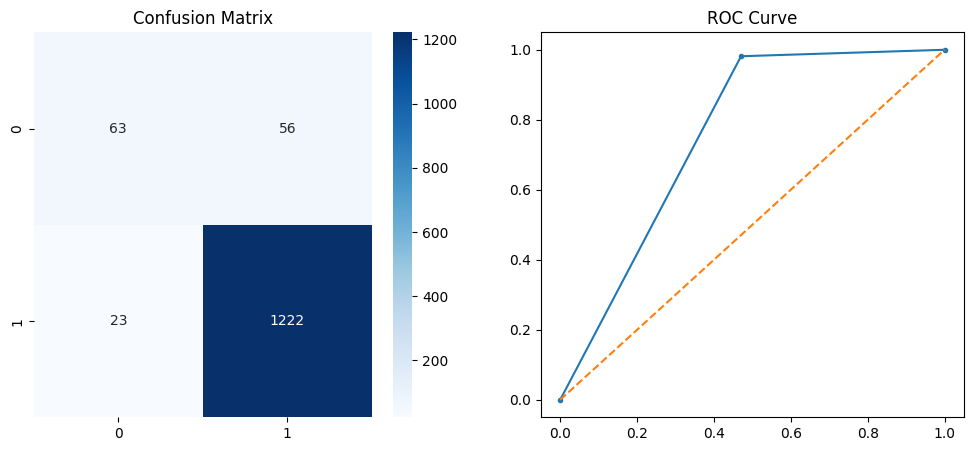

In [15]:
# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

# 혼동 행렬 및 ROC 곡선
conf_matrix = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')

plt.show()

True Positives (TP): 실제 긍정적 샘플 중 모델이 올바르게 예측한 수 (1250)

True Negatives (TN): 실제 부정적 샘플 중 모델이 올바르게 예측한 수 (25)

False Positives (FP): 실제 부정적 샘플 중 모델이 잘못 예측한 수 (88)

False Negatives (FN): 실제 긍정적 샘플 중 모델이 잘못 예측한 수 (2)

현재 위의 수치만 보면 문제점이 당장은 없어 보인다. 하지만 ROC 모양이 기형적이기에

어디서 문제인지 확인 중 모델 예측 분포를 검사

1    1278
0      86
Name: count, dtype: int64


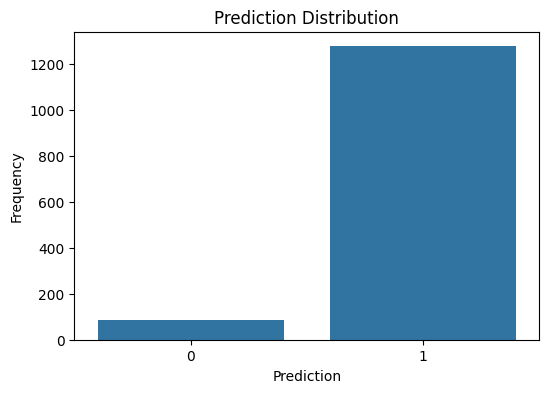

In [16]:
#모델 예측 분포 검사
pred_counts = pd.Series(y_pred).value_counts()
print(pred_counts)

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x=pred_counts.index, y=pred_counts.values)
plt.title('Prediction Distribution')
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.show()

보시다시피 부정보다 긍정으로 평가한 경우가 매우 많다. 이는 데이터가 긍정적인 표본에 과도하게 편향되어 있음을 보여줌

즉 특정 표본으로 인한 오버피팅이 발생

따라서 오버샘플링으로 부정적인 표본들을 늘이는 방식 제시 

Accuracy: 0.9340175953079178
Precision: 0.9586973788721207
Recall: 0.9694779116465864
F1 Score: 0.9640575079872205
ROC-AUC: 0.76625156086531


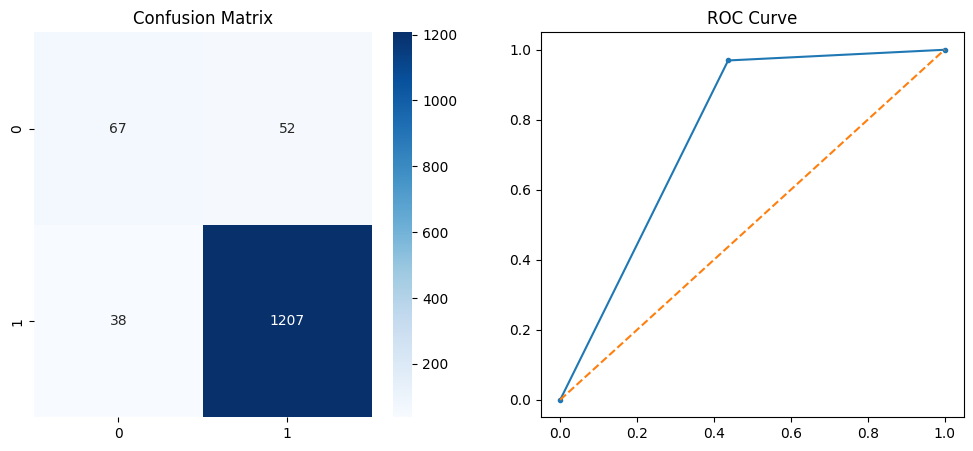

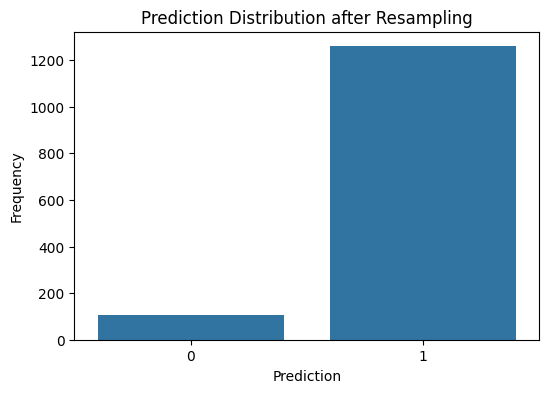

In [26]:
# 오버샘플링 비율 설정
sampling_strategy = 0.5  # 소수 클래스의 샘플 수가 다수 클래스의 50%가 되도록 설정

# 오버샘플링
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# 모델 재학습
model.fit(X_train_resampled, y_train_resampled)

# 예측
y_pred_resampled = model.predict(X_test_tfidf)

# 평가
accuracy = accuracy_score(y_test, y_pred_resampled)
precision = precision_score(y_test, y_pred_resampled)
recall = recall_score(y_test, y_pred_resampled)
f1 = f1_score(y_test, y_pred_resampled)
roc_auc = roc_auc_score(y_test, y_pred_resampled)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

# 혼동 행렬 및 ROC 곡선
conf_matrix = confusion_matrix(y_test, y_pred_resampled)
fpr, tpr, _ = roc_curve(y_test, y_pred_resampled)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')

plt.show()

# 예측 분포 확인
pred_counts_resampled = pd.Series(y_pred_resampled).value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=pred_counts_resampled.index, y=pred_counts_resampled.values)
plt.title('Prediction Distribution after Resampling')
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.show()

오버 샘플링으로 부정적인 표본에 대한 비율을 높였음

이로 인해 기존의 그래프보다 좌측 상단에 가까워진 모습을 보이며 AUC의 면적이 확대됨

하지만 여전히 직선에다가 이상적인 모델이라고 보기에는 문제가 있으며 이에 대한 고찰 또한 필요함

* 오버샘플링 이전

Accuracy: 0.9340659340659341

Precision: 0.9342301943198804

Recall: 0.9984025559105432

F1 Score: 0.9652509652509652

ROC-AUC: 0.6098207469818202

* 오버샘플링 이후

Accuracy: 0.9296703296703297

Precision: 0.9745484400656814

Recall: 0.9480830670926518

F1 Score: 0.9611336032388664

ROC-AUC: 0.8368733919534055

= 해당 지표를 비교해보면 Accuracy, F1 score는 큰 차이가 없으나 precision은 0.04 상향, Recall은 0.03으로 하향되었는데

= 이는 오버피팅이 되어 있음을 보여주는 현상이며 ROC의 면적은 0.23이상 차이나며 오버샘플링이 유의미한 결과를 보여주고 있음을 시사

= 하지만 이상적인 모델이라고 보기에는 아직 개선의 여지가 있으며 이에 대한 고찰 또한 필요함